# L3: Measuring Cache Effectiveness

In this lab, you’ll learn how to evaluate your cache using metrics like hit rate, precision, recall, and latency to understand its real impact.


<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import time

from tqdm.auto import tqdm

from cache.evals import CacheEvaluator
from cache.faq_data_container import FAQDataContainer
from cache.wrapper import SemanticCacheWrapper
from cache.config import config, load_openai_key

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>
</div>

## Load Data and Recreate Cache

In [3]:
data_container = FAQDataContainer()
faq_df, test_df = data_container.faq_df, data_container.test_df

test_queries = test_df["question"].tolist()

Loaded 8 FAQ entries
Loaded 80 test queries


In [4]:
# Initialize semantic cache wrapper from config
cache_wrapper = SemanticCacheWrapper.from_config(config)

✅ Redis is running and accessible!
11:27:15 sentence_transformers.SentenceTransformer INFO   Use pytorch device_name: mps
11:27:15 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: redis/langcache-embed-v1


## Evaluating cache quality

In [5]:
# Cache hydration via wrapper helper
cache_wrapper.hydrate_from_df(faq_df)

cache_wrapper.check(faq_df["question"].iloc[0])

(Query: 'How do I get a refund?', Matches: ['How do I get a refund?'])

In [6]:
test_queries[:4]

["What's the process for getting my money back?",
 'How can I request a refund for my purchase?',
 'What steps do I follow to return an item for money back?',
 "What's your refund policy for digital products?"]

In [7]:
cache_results = cache_wrapper.check_many(test_queries)
cache_results[:4]

[(Query: 'What's the process for getting my money back?', Matches: ['How do I get a refund?']),
 (Query: 'How can I request a refund for my purchase?', Matches: ['How do I get a refund?']),
 (Query: 'What steps do I follow to return an item for money back?', Matches: ['How do I get a refund?']),
 (Query: 'What's your refund policy for digital products?', Matches: [])]

In [8]:
evaluator = CacheEvaluator(
    true_labels=data_container.label_cache_hits(cache_results),
    cache_results=cache_results,
)
evaluator.report_metrics()

Column
    [0] Markdown(str)
    [1] Row
        [0] DataFrame(DataFrame, width=200)
        [1] DataFrame(Styler)

In [9]:
[[tn, fp], [fn, tp]] = evaluator.get_metrics()["confusion_mask"]

In [10]:
tn[:9]

array([False, False, False,  True,  True, False,  True,  True,  True])

In [11]:
evaluator.matches_df()[fp]

,query,match,distance,true_label
5,Can I get a refund if I changed my mind?,How do I get a refund?,0.294378,False
24,Can I change my order after it's been placed?,Can I change my delivery address?,0.286985,False
53,How do I upgrade my subscription plan?,How do I cancel my subscription?,0.250155,False
55,Can I pause my subscription temporarily?,How do I cancel my subscription?,0.277127,False
75,Can I schedule a specific delivery time?,Can I change my delivery address?,0.286493,False


## Evaluating cache latency

In [12]:
def simulate_llm_call(prompt):
    time.sleep(np.random.uniform(0.2, 0.5))
    return f"LLM response to {prompt}"

In [13]:
from cache.evals import PerfEval

perf_eval = PerfEval()

with perf_eval:
    for query in tqdm(test_queries):
        cache_wrapper.check(query)
        perf_eval.tick("cache_hit")
        perf_eval.start()
        simulate_llm_call(query)
        perf_eval.tick("llm_call")

metrics = perf_eval.get_metrics(labels=["cache_hit", "llm_call"])

100%|██████████| 80/80 [00:27<00:00,  2.88it/s]


In [14]:
metrics["by_label"]

{'cache_hit': {'count': 80,
  'average_latency': 7.9056233167648315,
  'p50': 6.928086280822754,
  'p90': 13.62874507904053,
  'p95': 15.350067615509031,
  'p99': 17.606165409088085,
  'average_throughput': 126492.23975538765},
 'llm_call': {'count': 80,
  'average_latency': 339.4731342792511,
  'p50': 324.3170976638794,
  'p90': 479.1351556777954,
  'p95': 488.9754056930542,
  'p99': 497.9378247261047,
  'average_throughput': 2945.7412060696342}}

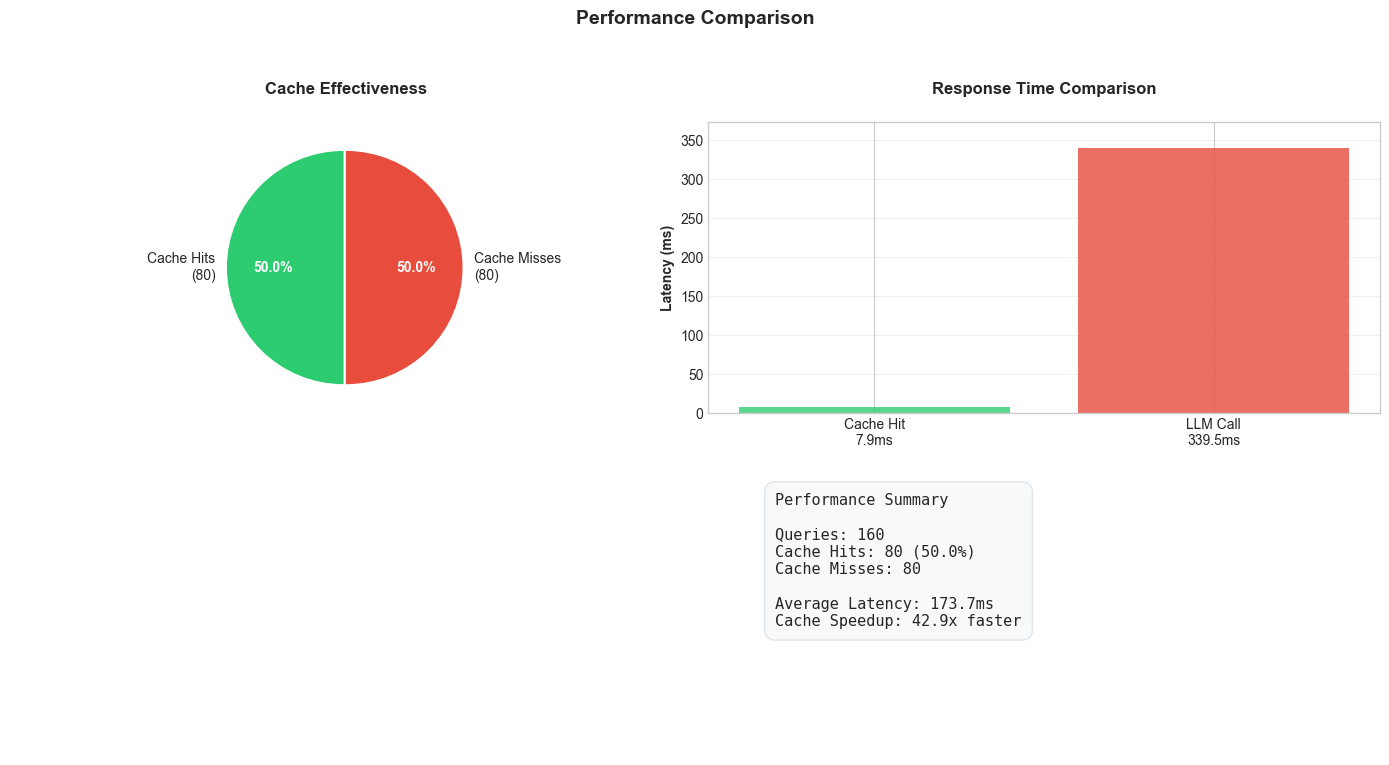

In [15]:
perf_eval.plot(
    title="Performance Comparison", show_cost_analysis=False
)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"><b>Note:</b> In the above experiment we measure the latency of the cache response and a mocked latency of an LLM call. The mocked LLM call is a dummy function that sleeps for a random amount of time. The randomness in the results mainly comes from the randomness we introduced to mock the LLM. The results show us what we can typically see in practice.</p>

In [16]:
llm_latency = metrics["by_label"]["llm_call"]["average_latency"]
cache_latency = metrics["by_label"]["cache_hit"]["average_latency"]

cache_hit_rate = 0.3
cached_llm_latency = llm_latency * (1 - cache_hit_rate) + cache_latency * cache_hit_rate
cached_llm_drop_in_latency = (llm_latency - cached_llm_latency) / llm_latency
cached_llm_speedup = llm_latency / cached_llm_latency
print(f"Overall latency drop of an LLM app: {int(cached_llm_drop_in_latency * 100)}%")
print(f"Overall speedup of an LLM app {cached_llm_speedup:.2f}x")

Overall latency drop of an LLM app: 29%
Overall speedup of an LLM app 1.41x


## LLM-as-a-Judge for cache quality evaluation

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output visualizations generated may differ from those shown in the video.</p>

In [17]:
cache_wrapper.hydrate_from_df(faq_df)

# we set the distance to obtain even bad matches and evaluate if they are true negatives
full_retrieval_nearest_neighbors = cache_wrapper.check_many(
    test_queries, distance_threshold=1
)
full_retrieval_matches = [h.matches[0].prompt for h in full_retrieval_nearest_neighbors]
full_retrieval_matches[:4]

['How do I get a refund?',
 'How do I get a refund?',
 'How do I get a refund?',
 'How do I get a refund?']

In [18]:
load_openai_key()

> OpenAI API key is already loaded in the environment


In [19]:
from cache.llm_evaluator import LLMEvaluator

evaluator = LLMEvaluator.construct_with_gpt()

In [20]:
llm_similarity_results = evaluator.predict(
    dataset=zip(test_queries, full_retrieval_matches),
    batch_size=5,
)

  0%|          | 0/16 [00:00<?, ?it/s]

11:27:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:56 openai._base_client INFO   Retrying request to /chat/completions in 0.426550 seconds
11:27:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:56 openai._base_client INFO   Retrying request to /chat/completions in 0.451039 seconds
11:27:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:56 openai._base_client INFO   Retrying request to /chat/completions in 0.433948 seconds
11:27:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:56 openai._base_client INFO   Retrying request to /chat/completions in 0.499799 seconds
11:27:56 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:56 openai._base_client INFO   Ret

  6%|▋         | 1/16 [00:03<00:50,  3.34s/it]

11:27:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:59 openai._base_client INFO   Retrying request to /chat/completions in 0.494256 seconds
11:27:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:59 openai._base_client INFO   Retrying request to /chat/completions in 0.448207 seconds
11:27:59 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:27:59 openai._base_client INFO   Retrying request to /chat/completions in 0.467265 seconds
11:27:59 openai._base_client INFO   Retrying request to /chat/completions in 0.486065 seconds
11:27:59 openai._base_client INFO   Ret

 12%|█▎        | 2/16 [00:05<00:37,  2.66s/it]

11:28:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:01 openai._base_client INFO   Retrying request to /chat/completions in 0.426766 seconds
11:28:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:01 openai._base_client INFO   Retrying request to /chat/completions in 0.400418 seconds
11:28:01 openai._base_client INFO   Retrying request to /chat/completions in 0.476583 seconds
11:28:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:01 openai._base_client INFO   Retrying request to /chat/completions in 0.436807 seconds
11:28:01 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:01 openai._base_client INFO   Ret

 19%|█▉        | 3/16 [00:07<00:29,  2.30s/it]

11:28:03 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:03 openai._base_client INFO   Retrying request to /chat/completions in 0.479801 seconds
11:28:03 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:03 openai._base_client INFO   Retrying request to /chat/completions in 0.385548 seconds
11:28:03 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:03 openai._base_client INFO   Retrying request to /chat/completions in 0.495591 seconds
11:28:03 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:03 openai._base_client INFO   Retrying request to /chat/completions in 0.436529 seconds
11:28:03 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:03 openai._base_client INFO   Ret

 25%|██▌       | 4/16 [00:09<00:24,  2.05s/it]

11:28:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:04 openai._base_client INFO   Retrying request to /chat/completions in 0.487426 seconds
11:28:04 openai._base_client INFO   Retrying request to /chat/completions in 0.464950 seconds
11:28:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:04 openai._base_client INFO   Retrying request to /chat/completions in 0.404921 seconds
11:28:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:04 openai._base_client INFO   Retrying request to /chat/completions in 0.401510 seconds
11:28:04 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:04 openai._base_client INFO   Ret

 31%|███▏      | 5/16 [00:10<00:20,  1.89s/it]

11:28:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:06 openai._base_client INFO   Retrying request to /chat/completions in 0.404715 seconds
11:28:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:06 openai._base_client INFO   Retrying request to /chat/completions in 0.485369 seconds
11:28:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:06 openai._base_client INFO   Retrying request to /chat/completions in 0.442668 seconds
11:28:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:06 openai._base_client INFO   Retrying request to /chat/completions in 0.388338 seconds
11:28:06 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:06 openai._base_client INFO   Ret

 38%|███▊      | 6/16 [00:12<00:18,  1.81s/it]

11:28:08 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:08 openai._base_client INFO   Retrying request to /chat/completions in 0.389677 seconds
11:28:08 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:08 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:08 openai._base_client INFO   Retrying request to /chat/completions in 0.477254 seconds
11:28:08 openai._base_client INFO   Retrying request to /chat/completions in 0.398258 seconds
11:28:08 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:08 openai._base_client INFO   Retrying request to /chat/completions in 0.407760 seconds
11:28:08 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:08 openai._base_client INFO   Ret

 44%|████▍     | 7/16 [00:13<00:15,  1.73s/it]

11:28:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:09 openai._base_client INFO   Retrying request to /chat/completions in 0.393330 seconds
11:28:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:09 openai._base_client INFO   Retrying request to /chat/completions in 0.446980 seconds
11:28:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:09 openai._base_client INFO   Retrying request to /chat/completions in 0.482545 seconds
11:28:09 openai._base_client INFO   Retrying request to /chat/completions in 0.492832 seconds
11:28:09 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:09 openai._base_client INFO   Ret

 50%|█████     | 8/16 [00:15<00:13,  1.70s/it]

11:28:11 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:11 openai._base_client INFO   Retrying request to /chat/completions in 0.449043 seconds
11:28:11 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:11 openai._base_client INFO   Retrying request to /chat/completions in 0.417933 seconds
11:28:11 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:11 openai._base_client INFO   Retrying request to /chat/completions in 0.379799 seconds
11:28:11 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:11 openai._base_client INFO   Retrying request to /chat/completions in 0.488954 seconds
11:28:11 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:11 openai._base_client INFO   Ret

 56%|█████▋    | 9/16 [00:17<00:11,  1.67s/it]

11:28:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:12 openai._base_client INFO   Retrying request to /chat/completions in 0.381111 seconds
11:28:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:12 openai._base_client INFO   Retrying request to /chat/completions in 0.407566 seconds
11:28:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:12 openai._base_client INFO   Retrying request to /chat/completions in 0.453288 seconds
11:28:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:12 openai._base_client INFO   Retrying request to /chat/completions in 0.399039 seconds
11:28:12 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:12 openai._base_client INFO   Ret

 62%|██████▎   | 10/16 [00:18<00:09,  1.66s/it]

11:28:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:14 openai._base_client INFO   Retrying request to /chat/completions in 0.433966 seconds
11:28:14 openai._base_client INFO   Retrying request to /chat/completions in 0.441437 seconds
11:28:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:14 openai._base_client INFO   Retrying request to /chat/completions in 0.394334 seconds
11:28:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:14 openai._base_client INFO   Retrying request to /chat/completions in 0.403047 seconds
11:28:14 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:14 openai._base_client INFO   Ret

 69%|██████▉   | 11/16 [00:20<00:08,  1.62s/it]

11:28:16 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:16 openai._base_client INFO   Retrying request to /chat/completions in 0.418887 seconds
11:28:16 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:16 openai._base_client INFO   Retrying request to /chat/completions in 0.400467 seconds
11:28:16 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:16 openai._base_client INFO   Retrying request to /chat/completions in 0.389695 seconds
11:28:16 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:16 openai._base_client INFO   Retrying request to /chat/completions in 0.421746 seconds
11:28:16 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:16 openai._base_client INFO   Ret

 75%|███████▌  | 12/16 [00:22<00:06,  1.72s/it]

11:28:17 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:17 openai._base_client INFO   Retrying request to /chat/completions in 0.425442 seconds
11:28:17 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:17 openai._base_client INFO   Retrying request to /chat/completions in 0.433452 seconds
11:28:17 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:17 openai._base_client INFO   Retrying request to /chat/completions in 0.392825 seconds
11:28:17 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:17 openai._base_client INFO   Retrying request to /chat/completions in 0.396285 seconds
11:28:17 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:17 openai._base_client INFO   Ret

 81%|████████▏ | 13/16 [00:23<00:04,  1.64s/it]

11:28:19 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:19 openai._base_client INFO   Retrying request to /chat/completions in 0.482613 seconds
11:28:19 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:19 openai._base_client INFO   Retrying request to /chat/completions in 0.494934 seconds
11:28:19 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:19 openai._base_client INFO   Retrying request to /chat/completions in 0.430212 seconds
11:28:19 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:19 openai._base_client INFO   Retrying request to /chat/completions in 0.444495 seconds
11:28:19 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:19 openai._base_client INFO   Ret

 88%|████████▊ | 14/16 [00:25<00:03,  1.64s/it]

11:28:21 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:21 openai._base_client INFO   Retrying request to /chat/completions in 0.462644 seconds
11:28:21 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:21 openai._base_client INFO   Retrying request to /chat/completions in 0.380351 seconds
11:28:21 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:21 openai._base_client INFO   Retrying request to /chat/completions in 0.432367 seconds
11:28:21 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:21 openai._base_client INFO   Retrying request to /chat/completions in 0.379815 seconds
11:28:21 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
11:28:21 openai._base_client INFO   Ret

 88%|████████▊ | 14/16 [00:26<00:03,  1.92s/it]


KeyboardInterrupt: 

In [ ]:
llm_similarity_results.df.head()

,reason,is_similar
0,Both sentences are asking about the procedure ...,True
1,Both sentences ask about the process of obtain...,True
2,Sentence1 asks about the procedure to return a...,True
3,Sentence1 is specifically asking about the ref...,False
4,Sentence1 is asking about the cost involved in...,False


In [ ]:
# When evaluation is based on full retrieval we should use this constructor
evaluator = CacheEvaluator.from_full_retrieval(
    true_labels=llm_similarity_results.df["is_similar"].values,
    cache_results=cache_wrapper.check_many(test_queries),
)
evaluator.report_metrics()

Column
    [0] Markdown(str)
    [1] Row
        [0] DataFrame(DataFrame, width=200)
        [1] DataFrame(Styler)

In [ ]:
cache_wrapper.cache.clear()